# Create Session Report

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pynwb import NWBHDF5IO

from spiketools.measures import compute_spike_rate
from spiketools.spatial.occupancy import compute_occupancy

from spiketools.plts.data import plot_bar, plot_hist, plot_polar_hist
from spiketools.plts.space import plot_heatmap, plot_positions
from spiketools.plts.spikes import plot_unit_frs
from spiketools.utils.trials import epoch_data_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from reports import *

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Define bins to use
bins = [9, 12]
min_occ = 1

## Load Data

In [8]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [9]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

### Subject Information

In [10]:
# Get the subject & session ID from file
subj_id = nwbfile.subject.subject_id
session_id = nwbfile.session_id

### Epoch Information

In [11]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

### Position Information

In [12]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:], 
              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-10, 10])]

In [13]:
# Get position, speed and head direction information
positions = nwbfile.acquisition['position']['player_position'].data[:].T
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

# Get head directions
hd_degrees = nwbfile.acquisition['position']['head_direction'].data[:]

# Get chest positions
chest_positions = nwbfile.acquisition['chest_positions']['chest_positions'].data[:].T

In [14]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

### Occupancy

In [15]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, 
                        speed, minimum=min_occ,
                        area_range=area_range, set_nan=True)

## Behavioural Information

In [16]:
# Count confidence answers
conf_counts = Counter(nwbfile.trials.confidence_response.data[:])

In [17]:
# Fix confidence answers
for el in ['yes', 'maybe', 'no']:
    if el not in conf_counts:
        conf_counts[el] = 0

## Unit Information

In [18]:
# Get unit information
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)

In [19]:
# Compute firing rates for all units marked to keep
frs = [compute_spike_rate(nwbfile.units.get_unit_spike_times(uind)) \
       for uind in keep_inds]

## Create Report

In [20]:
# Report settings
font_settings = {'fontdict' : {'fontsize' : 14}, 'ha' : 'center', 'va' : 'center'}

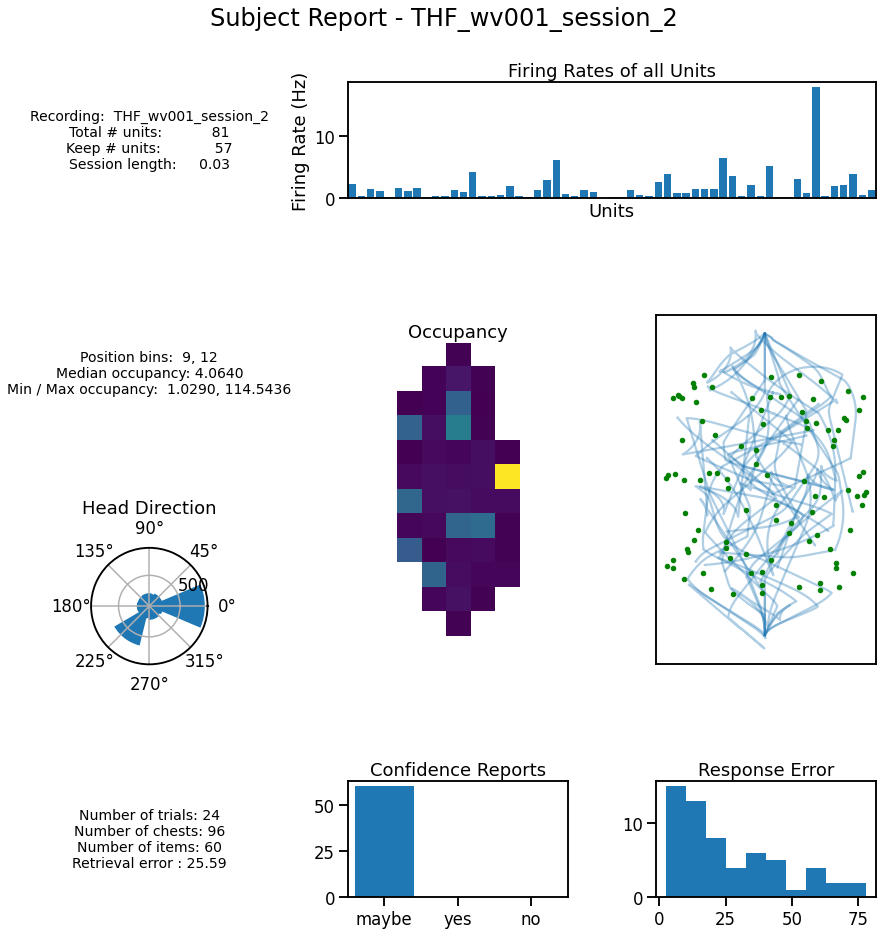

In [21]:
# Initialize figure
_ = plt.figure(figsize=(15, 15))
grid = gridspec.GridSpec(4, 3, wspace=0.4, hspace=1.0)
plt.suptitle('Subject Report - {}'.format(session_id), fontsize=24, y=0.95);

# 00: subject text
ax00 = plt.subplot(grid[0, 0])
subject_text = create_subject_str(create_subject_info(nwbfile))
ax00.text(0.5, 0.5, subject_text, **font_settings);
ax00.axis('off');

# 01: neuron fig
ax01 = plt.subplot(grid[0, 1:])
plot_unit_frs(frs, ax=ax01)
ax01.set(xticks=[])

# 10: position text
ax10 = plt.subplot(grid[1, 0])
position_text = create_position_str(bins, occ)
ax10.text(0.5, 0.5, position_text, **font_settings);
ax10.axis('off');

# 11: occupancy map
ax11 = plt.subplot(grid[1:3, 1])
plot_heatmap(occ, transpose=True, title='Occupancy', ax=ax11)

# 12: subject positions overlaid with chest positions
ax12 = plt.subplot(grid[1:3, 2])
plot_positions(positions_trials, ax=ax12)
ax12.plot(*chest_positions, '.g');

# 20: head direction
ax20 = plt.subplot(grid[2, 0], polar=True)
plot_polar_hist(hd_degrees, title='Head Direction', ax=ax20)

# 30: behaviour text
ax20 = plt.subplot(grid[3, 0])
behav_text = create_behav_str(create_behav_info(nwbfile))
ax20.text(0.5, 0.5, behav_text, **font_settings);
ax20.axis('off');

# 31: choice point plot
ax21 = plt.subplot(grid[3, 1])
plot_bar(conf_counts.values(), conf_counts.keys(), title='Confidence Reports', ax=ax21)

# 32: errors plot
ax22 = plt.subplot(grid[3, 2])
plot_hist(nwbfile.trials.error.data[:], title='Response Error', ax=ax22)